<a href="https://colab.research.google.com/github/tanishi22/FYP/blob/main/Code/ML/binary_classifiers_intrinsic_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Gene Essentiality Prediction with 5-fold Cross Validation: Intrinsic Features**

Trial ML prediction pipeline with intrinsic features only.

Intrinsic features (n = 10020) across all essential (n = 2081) and non-essential genes (n = 3764) have been extracted and merged into a single dataframe called intrinsic_df. This dataframe has all the corresponding essentiality labels for the FBgn_IDs. Initially, I'll just do essential vs non-essential prediction, and then stratify this further into the sterile/lethal dom/rec phenotypes for multi-label classification.

**Important links:**

Feature selection: https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel

Cross validation: https://scikit-learn.org/stable/modules/cross_validation.html

ROC interpretation on CV data: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

Hyperparameter tuning: https://scikit-learn.org/stable/modules/grid_search.html

Assessing feature importance: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, make_scorer, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier

import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change file path accordingly
file_path = "/content/drive/My Drive/ICL/FYP/Data/intrinsic_df.csv"

In [ ]:
# Load data and inspect dimensions and labels
intrinsic_df = pd.read_csv(file_path)
intrinsic_df.head()

,Unnamed: 0,FBgn_ID,gc_content,theoretical_pi,Tiny,Small,Aliphatic,Aromatic,Non.polar,Polar,...,Num_Isoforms,Longest_Isoform_Length,mode_chromosome_name,gene_length,coding_gene_length,five_utr_length,three_utr_length,cdna_coding_length,exon_chrom_length,label
0,0,FBgn0010612,0.583333,4.759690,0.303030,0.505051,0.272727,0.101010,0.626263,0.373737,...,3.0,300.0,2L,878.0,150.000000,26.5,380.0,150.000000,244.333333,1
1,1,FBgn0003517,0.622386,9.776537,0.266667,0.525926,0.229630,0.100000,0.540741,0.459259,...,4.0,813.0,X,1617.0,406.500000,132.0,90.0,406.500000,517.500000,1
2,2,FBgn0015376,0.519450,5.507063,0.273917,0.485398,0.199396,0.099698,0.491440,0.508560,...,1.0,2982.0,2L,4519.0,248.500000,130.0,124.0,248.500000,269.666667,1
3,3,FBgn0004868,0.573574,8.674255,0.259594,0.469526,0.225734,0.117381,0.539503,0.460497,...,3.0,1332.0,2L,3701.0,444.000000,181.0,148.0,444.000000,553.666667,1
4,4,FBgn0013733,0.526800,5.500341,0.261442,0.481772,0.227144,0.065531,0.457240,0.542760,...,22.0,26418.0,2R,77874.0,978.444444,153.5,1117.0,978.444444,994.357143,1


In [ ]:
intrinsic_df.tail()

,Unnamed: 0,FBgn_ID,gc_content,theoretical_pi,Tiny,Small,Aliphatic,Aromatic,Non.polar,Polar,...,Num_Isoforms,Longest_Isoform_Length,mode_chromosome_name,gene_length,coding_gene_length,five_utr_length,three_utr_length,cdna_coding_length,exon_chrom_length,label
5840,5840,FBgn0052058,0.380372,8.825593,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1722.0,3L,1722.0,1722.00,NaN,NaN,1722.00,1722.000000,0
5841,5841,FBgn0267489,0.361912,7.850448,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,3744.0,Y,45929.0,1248.00,NaN,NaN,1248.00,1248.000000,0
5842,5842,FBgn0065109,0.427466,5.054814,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1551.0,2L,3876.0,387.75,NaN,276.833333,387.75,356.888889,0
5843,5843,FBgn0267429,0.382576,5.888419,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1848.0,3L,434041.0,264.00,32.0,55.000000,264.00,245.875000,0
5844,5844,FBgn0259727,0.497835,8.431405,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,231.0,2R,2376.0,77.00,98.0,1930.000000,77.00,753.000000,0


In [ ]:
print(intrinsic_df["label"].value_counts(dropna=False))

label
0    3764
1    2081
Name: count, dtype: int64


In [ ]:
# Drop FBgn_ID and any unnamed index column
intrinsic_features = intrinsic_df.drop(columns=[col for col in ['FBgn_ID', 'Unnamed: 0'] if col in intrinsic_df.columns])
intrinsic_features.head()

,gc_content,theoretical_pi,Tiny,Small,Aliphatic,Aromatic,Non.polar,Polar,Charged,Basic,...,Num_Isoforms,Longest_Isoform_Length,mode_chromosome_name,gene_length,coding_gene_length,five_utr_length,three_utr_length,cdna_coding_length,exon_chrom_length,label
0,0.583333,4.759690,0.303030,0.505051,0.272727,0.101010,0.626263,0.373737,0.191919,0.131313,...,3.0,300.0,2L,878.0,150.000000,26.5,380.0,150.000000,244.333333,1
1,0.622386,9.776537,0.266667,0.525926,0.229630,0.100000,0.540741,0.459259,0.259259,0.111111,...,4.0,813.0,X,1617.0,406.500000,132.0,90.0,406.500000,517.500000,1
2,0.519450,5.507063,0.273917,0.485398,0.199396,0.099698,0.491440,0.508560,0.278953,0.154079,...,1.0,2982.0,2L,4519.0,248.500000,130.0,124.0,248.500000,269.666667,1
3,0.573574,8.674255,0.259594,0.469526,0.225734,0.117381,0.539503,0.460497,0.288939,0.142212,...,3.0,1332.0,2L,3701.0,444.000000,181.0,148.0,444.000000,553.666667,1
4,0.526800,5.500341,0.261442,0.481772,0.227144,0.065531,0.457240,0.542760,0.308234,0.151732,...,22.0,26418.0,2R,77874.0,978.444444,153.5,1117.0,978.444444,994.357143,1


In [ ]:
# Define features and target
X = intrinsic_features.drop(columns=["label"]) # drop essentiality labels
y = intrinsic_features["label"]

# Split data (90/10) while preserving class balance (stratify=y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

# Stratified 5-fold cross-validation - for cross validation after prelim models have been attempted
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# check datatypes per column
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")

Numerical columns: 10018
Categorical columns: 1


In [ ]:
# Define columns to be transformed. Note, all intrinsic features are numerical except for mode_chromosome_name
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

In [ ]:
# Create pre-processing transformer for numerical and categorical features. Will be input into ColumnTransformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

In [ ]:
# Start with Dummy classifier - provides a baseline to evaluate if the trained models perform better than random guessing.
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
# my models should perform much better than this one does at random

# Define dummy pipeline with only general preprocessing
dummy_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('variance', VarianceThreshold(threshold=0.01)),
    ('clf', DummyClassifier(strategy='uniform'))  # can change strategy to 'stratified' or 'most_frequent' or 'uniform'
])

# Evaluate baseline with 5-fold CV
dummy_results = cross_validate(dummy_pipeline, X, y, cv=cv, scoring='accuracy', verbose = True)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.8s finished


In [ ]:
print("Dummy classifier accuracy scores:", dummy_results['test_score'])
print(f"Mean Dummy Accuracy: {dummy_results['test_score'].mean():.4f}")

Dummy classifier accuracy scores: [0.4893071  0.51240376 0.48331908 0.52010265 0.48845167]
Mean Dummy Accuracy: 0.4987


**Baseline performance with DummyClassifier:**
- `most_frequent` (predicting only non-essential genes) gives ~64.4% accuracy — the highest baseline, probably due to class imbalance.
- `stratified` (random prediction based on label distribution) gives ~54.0% accuracy.
- `uniform` (purely random guessing) gives ~49.8% accuracy.

In [ ]:
# Preliminary, basic  pipeline with pre-processing, low variance filtering, univariate- and model-based feature selection, and training on RF predictor
rf_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('variance', VarianceThreshold(threshold=0.01)), # removing constant and quasi constant features, first-pass
    ('select_kbest', SelectKBest(score_func=f_classif, k = 1000)), # filters top 1000 features by ANOVA F-score univariate test
    ('select_model', SelectFromModel(ExtraTreesClassifier(n_estimators=100, class_weight='balanced'))), # tree-based feature selection
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)) # accounting for class weights
],
                       verbose = True)

In [ ]:
# Fit pipeline to training data - click each step in the figure below to see the parameters for each step
rf_pipeline.fit(X_train, y_train)

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   4.1s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.4s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   6.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   6.9s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gc_content',
                                                   'theoretical_pi', 'Tiny',
                                                   'Small', 'Aliphatic',
                                                   'Aromatic', 'Non.polar',
                                                   'Polar', 'Charged', 'Basic',
                                                   'Acidic', 'Twist.lag1',
                                                   'Twist.lag2', 'Tilt.lag1',
                                                   'Tilt.lag2',
                                                   'Twist.Tilt.lag.1',
                                                   'Twist.Tilt.lag.2',...
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['mode_chromosome_name'])])),
                ('variance', VarianceThreshold(threshold=0.01)),
                ('select_kbest', SelectKBest(k=1000)),
                ('select_model',
                 SelectFromModel(estimator=ExtraTreesClassifier(class_weight='balanced'))),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))],
         verbose=True)

In [ ]:
# Apply to testing set
from sklearn.metrics import classification_report, confusion_matrix
y_train_pred = rf_pipeline.predict(X_train)
y_test_pred = rf_pipeline.predict(X_test)


# Performance metrics
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3387
           1       1.00      1.00      1.00      1873

    accuracy                           1.00      5260
   macro avg       1.00      1.00      1.00      5260
weighted avg       1.00      1.00      1.00      5260

Test Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       377
           1       0.73      0.75      0.74       208

    accuracy                           0.81       585
   macro avg       0.79      0.80      0.79       585
weighted avg       0.81      0.81      0.81       585



In [ ]:
# Perform cross-validation on the same RF pipeline, based on class-stratified 5-fold CV which was defined when splitting train/test
cv_results = cross_validate(rf_pipeline, X, y, cv=cv, scoring='accuracy', return_train_score=False)

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   5.1s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.9s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   2.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  16.2s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  11.1s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   5.1s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   2.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   2.4s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   5.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   6.7s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.5s
[Pipel

In [ ]:
# Print cross-validation results
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

Cross-validation scores:  [0.81864842 0.80667237 0.79298546 0.80153978 0.77929855]
Mean CV accuracy: 0.7998
Standard deviation of CV accuracy: 0.0132


In [ ]:
# get roc auc scores
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer

# Replace scoring='accuracy' with a ROC-AUC scorer:
roc_scorer = make_scorer(roc_auc_score)

cv_results = cross_validate(
    rf_pipeline,
    X,
    y,
    cv=cv,
    scoring=roc_scorer,
    return_train_score=False
)

print("Cross-validation ROC-AUC scores:", cv_results['test_score'])
print(f"Mean CV ROC-AUC: {np.mean(cv_results['test_score']):.4f}")
print(f"Std CV ROC-AUC: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   6.1s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   2.3s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.5s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   5.2s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   7.4s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.6s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   6.1s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   5.9s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.7s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.4s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.6s
[Pipel

In [ ]:
#  To see detailed performance metrics, compute classification reports for each fold manually:
for fold, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the pipeline on the training data
    rf_pipeline.fit(X_train, y_train)

    # Predict on the test data
    y_pred = rf_pipeline.predict(X_test)

    # Print classification report for each fold
    print(f"\nFold {fold + 1} Classification Report:")
    print(classification_report(y_test, y_pred))


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       752
           1       0.79      0.70      0.74       417

    accuracy                           0.83      1169
   macro avg       0.82      0.80      0.80      1169
weighted avg       0.82      0.83      0.82      1169


Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       753
           1       0.72      0.73      0.73       416

    accuracy                           0.81      1169
   macro avg       0.79      0.79      0.79      1169
weighted avg       0.81      0.81      0.81      1169


Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       753
           1       0.70      0.72      0.71       416

    accuracy                           0.79      1169
   macro avg       0.77      0.77  

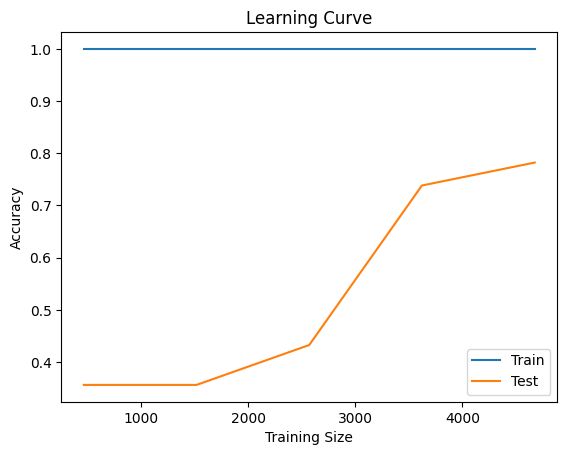

In [ ]:
# Plot learning curve to see if the model is overfitting training data
# Result: Clear overfitting!! Training accuracy does not increase as training set increases. Hyperparameter tuning needed.
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    rf_pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()

In [ ]:
# check data dimensionality post-processing
from sklearn.compose import make_column_selector
rf_pipeline.named_steps["preprocessing"].fit(X_train)
X_processed = rf_pipeline.named_steps["preprocessing"].transform(X_train)
print(X_processed.shape)

(5260, 10028)


In [ ]:
# Trying RF predictor without tree-based feature selection to see if that's resulting in the model overfitting the training data
# All other transformers and parameters remain the same
rf_pipeline_2 = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('variance', VarianceThreshold(threshold=0.01)), # removing constant and quasi constant features, first-pass
    ('select_kbest', SelectKBest(score_func=f_classif, k = 1000)), # filters top 1000 features by ANOVA F-score univariate test
    ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)) # accounting for class weights
],
                       verbose = True)

In [ ]:
rf_pipeline_2.fit(X_train, y_train)
y_train_pred = rf_pipeline_2.predict(X_train)
y_test_pred = rf_pipeline_2.predict(X_test)


# Performance metrics
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

[Pipeline] ..... (step 1 of 4) Processing preprocessing, total=   8.1s
[Pipeline] .......... (step 2 of 4) Processing variance, total=   2.0s
[Pipeline] ...... (step 3 of 4) Processing select_kbest, total=   2.9s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  17.7s
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3387
           1       1.00      1.00      1.00      1873

    accuracy                           1.00      5260
   macro avg       1.00      1.00      1.00      5260
weighted avg       1.00      1.00      1.00      5260

Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       377
           1       0.79      0.50      0.61       208

    accuracy                           0.78       585
   macro avg       0.78      0.71      0.73       585
weighted avg       0.78      0.78      0.76       585



In [ ]:
# Perform cross-validation on the same RF pipeline, based on class-stratified 5-fold CV which was defined when splitting train/test
cv_results = cross_validate(rf_pipeline_2, X, y, cv=cv, scoring='accuracy', return_train_score=False)
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 4) Processing preprocessing, total=   4.1s
[Pipeline] .......... (step 2 of 4) Processing variance, total=   2.0s
[Pipeline] ...... (step 3 of 4) Processing select_kbest, total=   2.5s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  21.0s
[Pipeline] ..... (step 1 of 4) Processing preprocessing, total=   5.7s
[Pipeline] .......... (step 2 of 4) Processing variance, total=   3.0s
[Pipeline] ...... (step 3 of 4) Processing select_kbest, total=   1.9s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  19.9s
[Pipeline] ..... (step 1 of 4) Processing preprocessing, total=   3.5s
[Pipeline] .......... (step 2 of 4) Processing variance, total=   1.6s
[Pipeline] ...... (step 3 of 4) Processing select_kbest, total=   1.2s
[Pipeline] ............... (step 4 of 4) Processing clf, total=  26.3s
[Pipeline] ..... (step 1 of 4) Processing preprocessing, total=   4.4s
[Pipeline] .......... (step 2 of 4) Processing variance, total=   1.7s
[Pipel

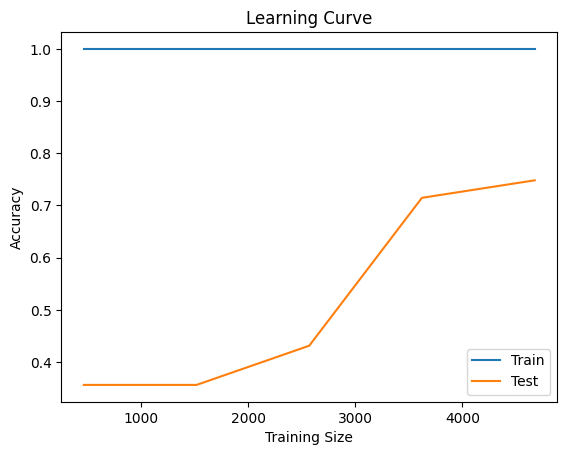

In [ ]:
# Plot learning curve to see if the model is overfitting training data
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
train_sizes, train_scores, test_scores = learning_curve(
    rf_pipeline_2, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()

Seems that the inclusion or exlcusion of a tree-based feature selection step has very little impact on RF overfitting to training data (precision/recall = 1.0 in training classification report for both).

**Hyperparameter tuning**

# **Trying different classifiers with same preliminary pipeline**

**LOGISTIC REGRESSION**

In [ ]:
# Logistic regression pipeline
# (L2 regularisation for now because ElasticNet is taking very long to run - will try again?)
lr_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('variance', VarianceThreshold(threshold=0.01)),
        ('select_kbest', SelectKBest(score_func=f_classif, k=1000)),
        ('select_model', SelectFromModel(ExtraTreesClassifier(n_estimators=100, class_weight='balanced'))),
        ('clf', LogisticRegression(penalty = 'l2', class_weight = 'balanced', random_state = 42, max_iter = 5000))
    ],
                    verbose = True)

lr_pipeline.fit(X_train, y_train)
# Train set performance
y_train_pred = lr_pipeline.predict(X_train)
print("LR Train Classification Report:\n", classification_report(y_train, y_train_pred))

# Test set performance
y_test_pred = lr_pipeline.predict(X_test)
print("LR Test Classification Report:\n", classification_report(y_test, y_test_pred))

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   5.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.5s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.7s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  10.6s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   7.3s
LR Train Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73      3387
           1       0.54      0.70      0.61      1873

    accuracy                           0.68      5260
   macro avg       0.67      0.69      0.67      5260
weighted avg       0.71      0.68      0.69      5260

LR Test Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.61      0.66       377
           1       0.44      0.56      0.50       208

    accuracy                           0.59       585
   macro avg       0.58      0.59  

In [ ]:
# get roc auc scores
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer

# Replace scoring='accuracy' with a ROC-AUC scorer:
roc_scorer = make_scorer(roc_auc_score)

cv_results = cross_validate(
    lr_pipeline,
    X,
    y,
    cv=cv,
    scoring=roc_scorer,
    return_train_score=False
)

print("Cross-validation ROC-AUC scores:", cv_results['test_score'])
print(f"Mean CV ROC-AUC: {np.mean(cv_results['test_score']):.4f}")
print(f"Std CV ROC-AUC: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   4.8s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.5s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.9s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   8.9s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   4.2s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   4.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.5s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   3.2s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   4.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.6s
[Pipel

In [ ]:
cv_results = cross_validate(lr_pipeline, X, y, cv=cv, scoring='accuracy', return_train_score=False)
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   5.0s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   7.5s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   3.4s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   7.4s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   4.3s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   8.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   5.3s
[Pipel

**Logistic regression appears to perform worse than the DummyClassifier**
- Hyperparameters have not been tuned
- Tree-based feature selection method has been applied to a linear model (non-linear features fit to a linear model)

In [ ]:
# Attempting a different feature selection model -- can do hyperparameter tuning for this estimator, too

# Define elastic net logistic regression model
elastic_net_lr = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    class_weight='balanced',
    l1_ratio = 0.5,
    max_iter= 10000, # did not coverge at max_iter = 1000 (2.5 min to run) or 5000 (12.5 min to run), so trying 10000 (13.2 min)
    random_state=42
)

lr_pipeline_2 = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('variance', VarianceThreshold(threshold=0.01)),
        ('select_kbest', SelectKBest(score_func=f_classif, k=1000)),
        ('clf', elastic_net_lr)
    ],
                    verbose = True)

lr_pipeline_2.fit(X_train, y_train)

# Train set performance
y_train_pred = lr_pipeline_2.predict(X_train)
print("LR Train Classification Report:\n", classification_report(y_train, y_train_pred))

# Test set performance
y_test_pred = lr_pipeline_2.predict(X_test)
print("LR Test Classification Report:\n", classification_report(y_test, y_test_pred))

[Pipeline] ..... (step 1 of 4) Processing preprocessing, total=   4.2s
[Pipeline] .......... (step 2 of 4) Processing variance, total=   1.3s
[Pipeline] ...... (step 3 of 4) Processing select_kbest, total=   1.7s
[Pipeline] ............... (step 4 of 4) Processing clf, total=13.2min
LR Train Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80      3387
           1       0.63      0.79      0.70      1873

    accuracy                           0.76      5260
   macro avg       0.75      0.77      0.75      5260
weighted avg       0.78      0.76      0.77      5260

LR Test Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.64      0.68       377
           1       0.46      0.55      0.50       208

    accuracy                           0.61       585
   macro avg       0.59      0.60      0.59       585
weighted avg       0.63      0.61      0.62       58

LR still performs really poorly even with ElasticNet regularisation. Can try hyperparameter tuning with LogisticRegressionCV, but this will take forever to compute, so do it later!

**SUPPORT VECTOR MACHINE (SVM)**

In [ ]:
# Support vector machine. Using default rbf kernel, but can change this to 'linear', 'poly', 'sigmoid' or 'precomputed'
svm_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('variance', VarianceThreshold(threshold=0.01)),
        ('select_kbest', SelectKBest(score_func=f_classif, k=1000)),
        ('select_model', SelectFromModel(ExtraTreesClassifier(n_estimators=100, class_weight='balanced'))),
        ('clf', SVC(kernel = 'rbf', class_weight = 'balanced',probability = True, random_state = 42 ))
    ],
                    verbose = True)

svm_pipeline.fit(X_train, y_train)
# Train set performance
y_train_pred = svm_pipeline.predict(X_train)
print("SVM Train Classification Report:\n", classification_report(y_train, y_train_pred))

# Test set performance
y_test_pred = svm_pipeline.predict(X_test)
print("SVM Test Classification Report:\n", classification_report(y_test, y_test_pred))


[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   4.4s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.4s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   6.5s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  33.3s
SVM Train Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89      3387
           1       0.75      0.95      0.84      1873

    accuracy                           0.87      5260
   macro avg       0.86      0.89      0.86      5260
weighted avg       0.89      0.87      0.87      5260

SVM Test Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76       377
           1       0.58      0.70      0.63       208

    accuracy                           0.71       585
   macro avg       0.69      0.71

In [ ]:
# get roc auc scores
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer

# Replace scoring='accuracy' with a ROC-AUC scorer:
roc_scorer = make_scorer(roc_auc_score)

cv_results = cross_validate(
    svm_pipeline,
    X,
    y,
    cv=cv,
    scoring=roc_scorer,
    return_train_score=False
)

print("Cross-validation ROC-AUC scores:", cv_results['test_score'])
print(f"Mean CV ROC-AUC: {np.mean(cv_results['test_score']):.4f}")
print(f"Std CV ROC-AUC: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.5s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.4s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  23.6s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.5s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   6.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  22.1s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.8s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.3s
[Pipel

In [ ]:
cv_results = cross_validate(svm_pipeline, X, y, cv=cv, scoring='accuracy', return_train_score=False)
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   4.8s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.3s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.5s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  21.8s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.1s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  19.4s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.3s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.5s
[Pipel

**Note, I'm using a tree-based feature selection method here which may be why the prediction accuracy for LR and SVM is low** -- nonlinear feature selection for a linear model. Feature selection should be LR and LinearSVC for LR and SVM, respectively, but I can't change this between classifiers if I want to do a fair comparison. Need to look at a model-agnostic feature selection method. However, I can continue to use ExtraTreeClassifier as my model for feature selection for all classifiers and perform hyperparameter tuning after

**GRADIENT BOOSTING CLASSIFIER**

In [ ]:
# Gradient Boosting Classifier
# Default 'log_loss' is used, which refers to binomial and multinomial deviance - same as what is used for logistic regression
gbm_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('variance', VarianceThreshold(threshold=0.01)),
        ('select_kbest', SelectKBest(score_func=f_classif, k=1000)),
        ('select_model', SelectFromModel(ExtraTreesClassifier(n_estimators=100, class_weight='balanced'))),
        ('clf', GradientBoostingClassifier(n_estimators = 100, loss = 'log_loss', random_state = 42))
    ],
                    verbose = True)

gbm_pipeline.fit(X_train, y_train)

# Train set performance
y_train_pred = gbm_pipeline.predict(X_train)
print("GBM Train Classification Report:\n", classification_report(y_train, y_train_pred))

# Test set performance
y_test_pred = gbm_pipeline.predict(X_test)
print("GBM Test Classification Report:\n", classification_report(y_test, y_test_pred))

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   5.3s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   2.9s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   2.6s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=  10.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total= 1.2min
GBM Train Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.92      3387
           1       0.80      0.98      0.88      1873

    accuracy                           0.91      5260
   macro avg       0.90      0.93      0.90      5260
weighted avg       0.92      0.91      0.91      5260

GBM Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.80      0.86       377
           1       0.71      0.90      0.79       208

    accuracy                           0.83       585
   macro avg       0.82      0.85

In [ ]:
cv_results = cross_validate(gbm_pipeline, X, y, cv=cv, scoring='accuracy', return_train_score=False)
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.3s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.4s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  39.0s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.4s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.5s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.8s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  39.3s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.4s
[Pipel

**XTREME GRADIENT BOOSTING (XGB)**

In [ ]:
# XGBoost
xgb_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('variance', VarianceThreshold(threshold=0.01)),
        ('select_kbest', SelectKBest(score_func=f_classif, k=1000)),
        ('select_model', SelectFromModel(ExtraTreesClassifier(n_estimators=100, class_weight='balanced'))),
        ('clf', XGBClassifier(n_estimators = 100, eval_metric = 'logloss',
                              scale_pos_weight = 1, random_state = 42))
    ],
                    verbose = True)

xgb_pipeline.fit(X_train, y_train)

# Train set performance
y_train_pred = xgb_pipeline.predict(X_train)
print("XGB Train Classification Report:\n", classification_report(y_train, y_train_pred))

# Test set performance
y_test_pred = xgb_pipeline.predict(X_test)
print("XGB Test Classification Report:\n", classification_report(y_test, y_test_pred))

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.3s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.3s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.5s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   6.1s
XGB Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3387
           1       1.00      1.00      1.00      1873

    accuracy                           1.00      5260
   macro avg       1.00      1.00      1.00      5260
weighted avg       1.00      1.00      1.00      5260

XGB Test Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86       377
           1       0.72      0.84      0.77       208

    accuracy                           0.83       585
   macro avg       0.81      0.83

In [ ]:
cv_results = cross_validate(xgb_pipeline, X, y, cv=cv, scoring='accuracy', return_train_score=False)
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.4s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.7s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   5.3s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.3s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.5s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   4.9s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.8s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   5.6s
[Pipel

**MULTI-LAYER PERCEPTRON (MLP) CLASSIFIER**

In [ ]:
# MLPClassifier - Multi-layer Perceptron classifier (Neural network)
# can try out different parameters
mlp_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('variance', VarianceThreshold(threshold=0.01)),
        ('select_kbest', SelectKBest(score_func=f_classif, k=1000)),
        ('select_model', SelectFromModel(ExtraTreesClassifier(n_estimators=100, class_weight='balanced'))),
        ('clf', MLPClassifier(hidden_layer_sizes=(100,),       # Single hidden layer with 100 neurons - a good starting point
        activation='relu',               # ReLU is standard for hidden layers; speeds up training and avoids vanishing gradients
        solver='adam',                   # Adam optimizer handles sparse gradients and noisy data well
        learning_rate='adaptive',       # Adjust learning rate during training if no improvement, helps convergence
        max_iter=300,
        random_state=42,
        early_stopping=True,            # Automatically stops training if validation score doesn't improve to prevent overfitting
        n_iter_no_change=10))
    ],
                    verbose = True)

mlp_pipeline.fit(X_train, y_train)

# Train set performance
y_train_pred = mlp_pipeline.predict(X_train)
print("MLP Train Classification Report:\n", classification_report(y_train, y_train_pred))

# Test set performance
y_test_pred = mlp_pipeline.predict(X_test)
print("MLP Test Classification Report:\n", classification_report(y_test, y_test_pred))

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.2s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.5s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.7s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   2.5s
MLP Train Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      3387
           1       0.95      0.95      0.95      1873

    accuracy                           0.96      5260
   macro avg       0.96      0.96      0.96      5260
weighted avg       0.96      0.96      0.96      5260

MLP Test Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81       377
           1       0.66      0.54      0.60       208

    accuracy                           0.74       585
   macro avg       0.72      0.70

In [ ]:
cv_results = cross_validate(mlp_pipeline, X, y, cv=cv, scoring='accuracy', return_train_score=False)
print("Cross-validation scores: ", cv_results['test_score'])
print(f"Mean CV accuracy: {np.mean(cv_results['test_score']):.4f}")
print(f"Standard deviation of CV accuracy: {np.std(cv_results['test_score']):.4f}")

[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   3.2s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.3s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.3s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   3.5s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   1.0s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.3s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.4s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   1.1s
[Pipeline] ..... (step 1 of 5) Processing preprocessing, total=   2.9s
[Pipeline] .......... (step 2 of 5) Processing variance, total=   1.1s
[Pipeline] ...... (step 3 of 5) Processing select_kbest, total=   1.2s
[Pipeline] ...... (step 4 of 5) Processing select_model, total=   4.5s
[Pipel

# **Statistical testing of Classifier Performance**

start with Friedman's test - non parametric statistical test used to compare three or more related groups, useufl when the data does not mean the assumption
of normality

Null hypothesis: All classifiers have the same median performance
If Friedman's test is significant (p < 0.05), then I can proceed to post-hoc comparisions with Wilcoxon signed-rank for each pair with a Bonferroni or Holm correction for multiple testing

In [ ]:
# create score matrix of the 5-fold CV results for all classifiers

scores = {
    "LogisticRegression" : np.array([0.6364414, 0.6201882, 0.62532079, 0.63130881, 0.61077844]),
    "SVM": np.array([]),
    "RandomForest": np.array([0.82720274, 0.803250]),
    "GradientBoosting": np.array([]),
    "XGBoost": np.array([]),
    "MLP": np.array([])
}

# **Visualise performance**

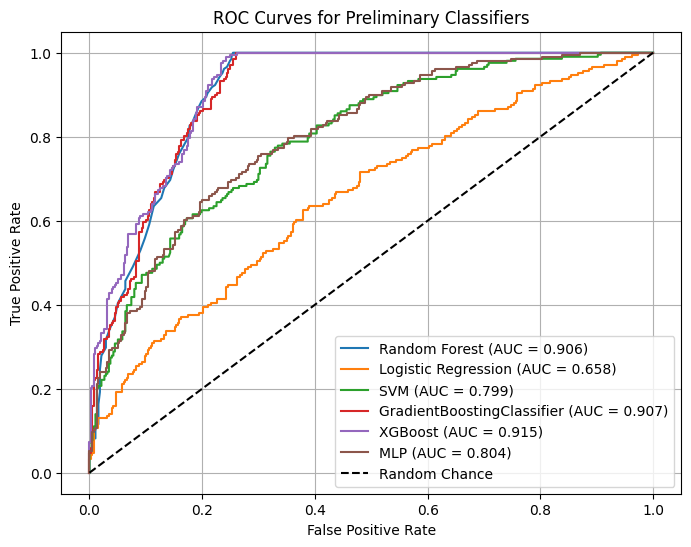

In [ ]:
# ROC-AUC (Receiver Operating Characteristic - Area Under Curve) measures the trade-off between True Positive Rate and False Positive Rate across
# thresholds. It's useful for balanced classes and provides an overall sense of model discrimination.

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Create dictionary of all fitted models
models = {
    'Random Forest': rf_pipeline,
    'Logistic Regression': lr_pipeline,
    'SVM': svm_pipeline,
    'GradientBoostingClassifier': gbm_pipeline,
    'XGBoost': xgb_pipeline,
    'MLP': mlp_pipeline,
}

plt.figure(figsize=(8, 6))

# Compute ROC-AUC curve iteratively for each model
for name, model in models.items():
    # Get predicted probabilities for the positive class (usually class 1)
    y_proba = model.predict_proba(X_test)[:, 1]

    #  ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    # AUC
    auc_score = roc_auc_score(y_test, y_proba)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

# Plot diagonal chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Preliminary Classifiers')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


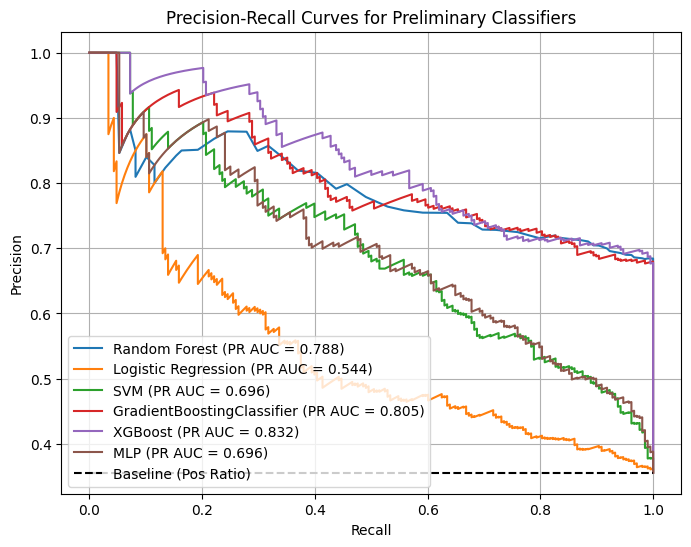

In [ ]:
# The overall essential vs non-essential classes aren't too imbalanced (1: 1.8), but the specific phenotypes (ie lethal/sterile dom/rec) will be.
# so need to consider PR-AUC curves. PR-AUC (Precision-Recall Area Under Curve) focuses on the trade-off between Precision and Recall.
# It shows how well the model identifies positive cases without too many false positives, so works better for imbalanced datasets.

from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Predicted probabilities for the positive class
    y_proba = model.predict_proba(X_test)[:, 1]

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    # PR-AUC score
    pr_auc_score = average_precision_score(y_test, y_proba)

    # Plot PR curve (recall on x-axis, precision on y-axis)
    plt.plot(recall, precision, label=f"{name} (PR AUC = {pr_auc_score:.3f})")

# Baseline for PR curve = positive class ratio (horizontal line)
pos_ratio = sum(y_test) / len(y_test)
plt.plot([0, 1], [pos_ratio, pos_ratio], 'k--', label='Baseline (Pos Ratio)')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Preliminary Classifiers')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

Next step is attempting elasticnet feature selection. It combines L1 + L2 penalties. However, it's designed for linear models -- would work well for LR, but may miss features important for tree- or kernel-based classifiers. After doing this, I can see the feature importances for each model.